__<center>3º Deliverable: Machine Learning</center>__

__<center>Life insurance policy</center>__

<div>
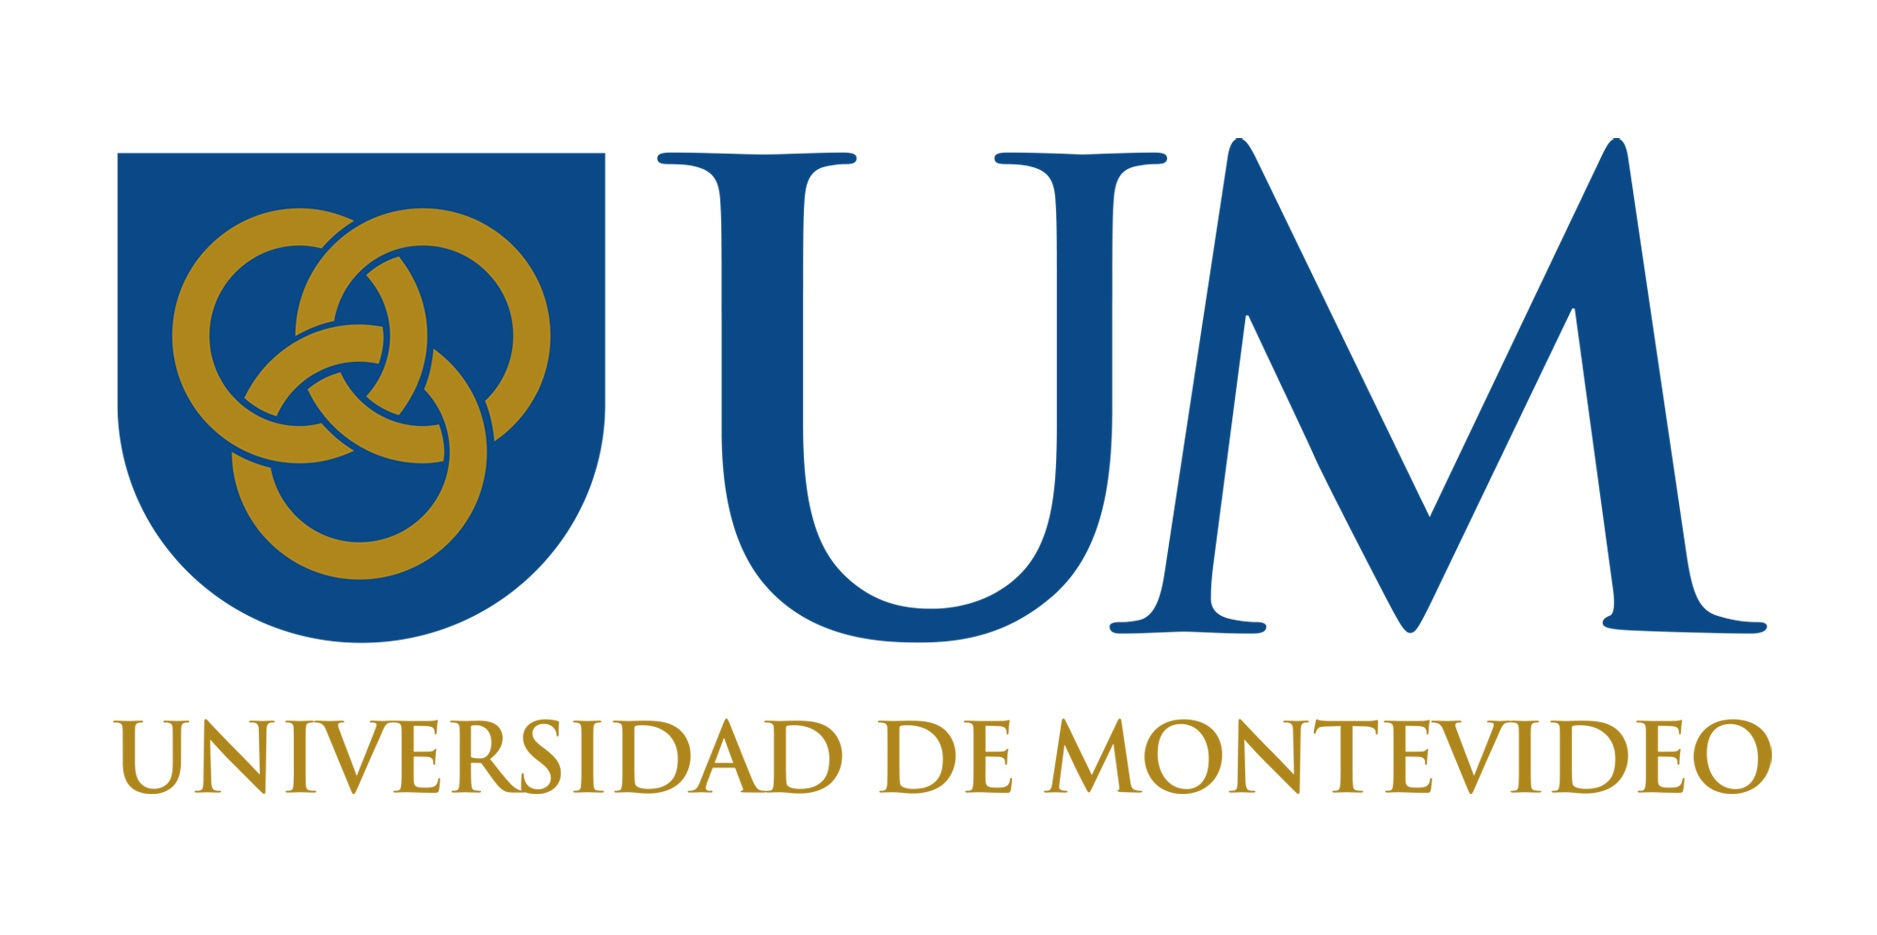
</div>


<center>Team VIII: Ariel Mordetzki and Mateo Stipaničić</center>
<center>Prof. Sebastián García Parra</center>
<center>17/10/2022</center>

___


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Outline" data-toc-modified-id="Outline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Outline</a></span></li></ul></div>



___

# Outline

The following is a commented code in Python that corresponds to the third task in Universidad de Montevideo's Machine Learning course. 

> __Context__ A life insurance carrier is wondering whether revenue could be increased, given the fact that apparently they have wrongly denied insurances to some clients.

> __Objectives__  The scope is dual: _(1)_ create a model that predicts whether additional information such as clinical records should be asked to an incoming client and _(2)_ create a model that identifies whether those given records signify a heart failure threat. The first one can be, too, divided in two: _(1.1)_ from the universe of past people who have asked a life insurance, what's the sub-group that should have been asked further information, instead of rejecting them and _(1.2)_ ponder if an incoming client belongs to such sub-group.

> __Problem definition__ Question _(1.1)_ is modelled as a clustering problem due to the lack of target labels <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1); _(1.2)_ as a classification problem with _(1.1)_'s clusters as classes; _(2)_ as a classification problem as well. 

> __Method__  


This approach takes an important assumption, that is, it is preferable to ask an incoming client his clinical records when it was not needed, and then correctly classify him as dangerous or not (in this way, there are two barriers to be skipped). In other words, both in problem _(1)_ and _(2)_ we try to avoid as much false positives <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-1) as possible (no incoming client with high risk of heart failure should be welcomed) but simultaneously, prevent the loss of clients, so in problem _(2)_,  there is also a vested interest in lowering false negatives as well.

The reasoning of this logic resides on the fact that a false negative means an operational cost, whereas a false positive implies "just" an opportunity cost (although it is true that these opportunity costs are the ones being searched for).


_Notes:_

<a name="cite_note-1"></a> [1](#cite_ref-1) The past data on whether the client was accepted or not could be interpreted as a label, or even heart failure history. However, we understand that if the insurance carrier is attempting to renew its client policy, it is only fair to construct the new labelling from the client universe's proper patterns, and not from the same policy that is wished to change.

<a name="cite_note-2"></a> [2](#cite_ref-2) Positive meaning no clinical record request or no heart failure risk, implying a "good" client (a false positive is thus someone who was labelled as a solid client, but in fact he was not). Instead, a false negative would be a client discarded that had no risk at all. The terms positive and negative could be interpreted conversely, but the idea is to strictly minimize the amount of clients at risk, and if possible, maximize healthy clients.

In [162]:
# data reading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Dataset
dataset_blood = pd.read_csv('heart_failure_clinical_records_dataset.csv')
# Show dataset format with first sample wines
dataset_blood.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [163]:

dataset_blood.shape

(299, 13)

In [164]:
dataset_blood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [165]:
dataset_blood.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [166]:
dataset_blood.describe(percentiles = [0.25, 0.50, 0.75])

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


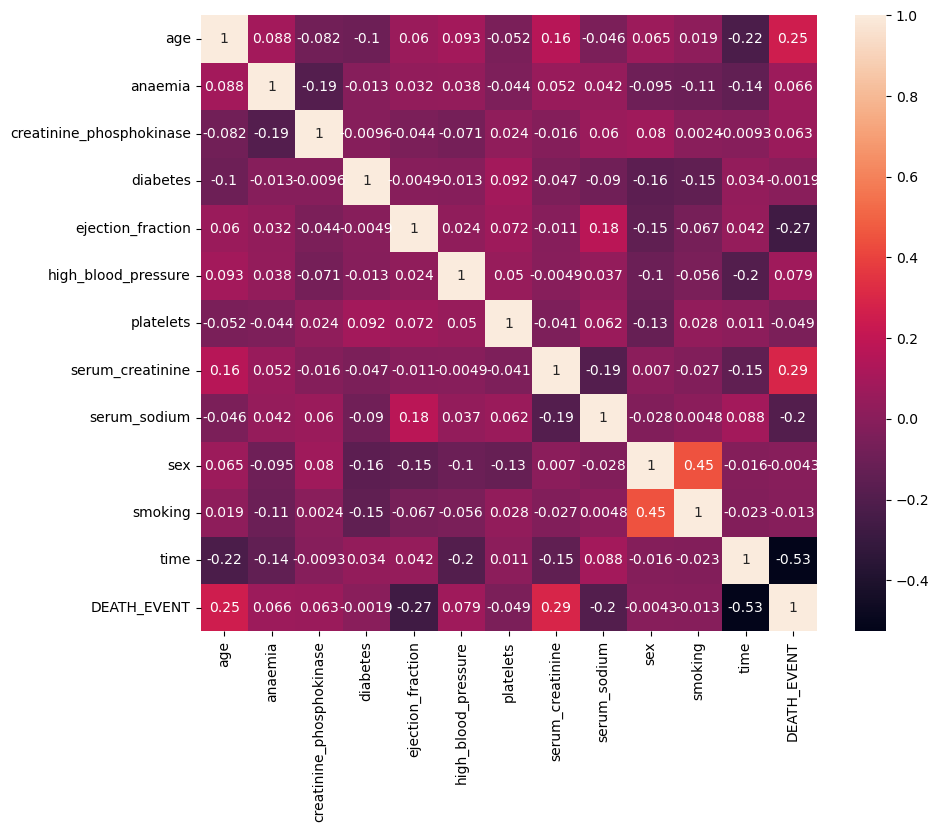

In [167]:
# Plotting correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
correlation = dataset_blood.corr()
sns.heatmap(correlation, mask=np.zeros_like(correlation, dtype=bool), square=True, ax=ax, annot=True)
plt.show()

## Falta un poco mas de EDA, alguna grafica o algo. No sabemos si esta balanceada o no

Text(0, 0.5, 'Cumulative Explained Variance')

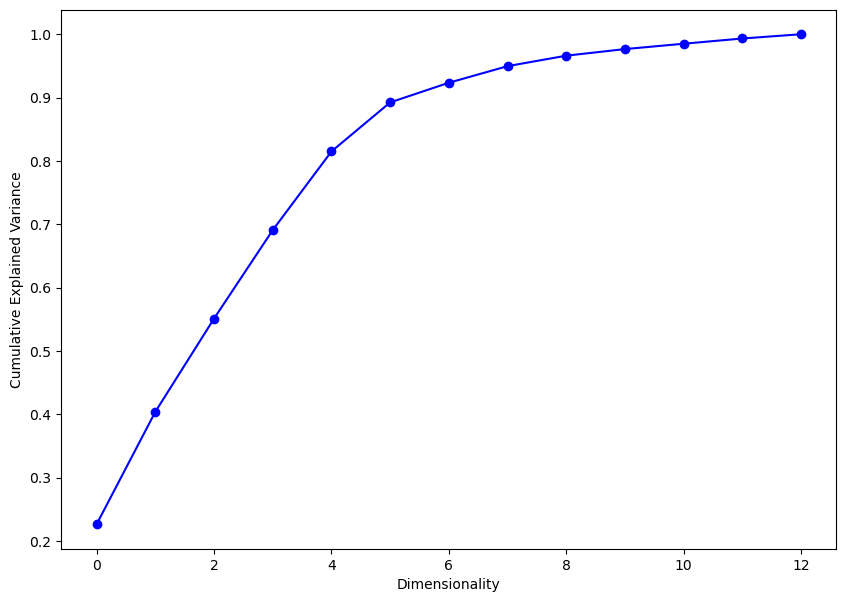

In [168]:
# detection of important features via random forest tree clasifier. Using the trees's nodes as a 
#means of unsupervised learning. 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
dataset_blood_scaled = pd.DataFrame(scaler.fit_transform(dataset_blood), columns = dataset_blood.columns)

pca = PCA()
pca.fit(dataset_blood_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Dimensionality')
plt.ylabel('Cumulative Explained Variance')

We notice that the 90% of the information lies within 6 dimensions (as opossed to 12). We could make the decision of reducing the dimensionality of the original dataset, but we discarded this idea in order to maintain the "white-box" character of the presented solution

# random forest in order


-Arboles para detectar features sanguineos importantes
-Clustering para detectar (con el dataset generado por nosotros) a quienes les mandamos hacerse analisis de sangre. “Recomender system”
-Usar dataset sanguineo origianl para entrenar un clasificador de “le doy poliza o no” a los que el “recomender system” indico analisis original


# Important clinical features
Using random forest/decision trees


In [169]:
X = dataset_blood_scaled.loc[:,dataset_blood_scaled.columns != 'DEATH_EVENT'] # features
y = dataset_blood_scaled ['DEATH_EVENT'] # target variable

#CUIDADO, NO ESCALA EL DATASET




In [170]:

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42) # answer





# Finding important variables using decision trees

In [171]:
max_depth=range(1,20)
training_accuracy = [] 
test_accuracy = []
training_f1 = []
test_f1 = []

for depth in max_depth : 
    tree = DecisionTreeClassifier(random_state=0, max_depth=depth, min_samples_leaf=1).fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_pred = tree.predict(X_test)
    
    training_accuracy.append(accuracy_score(y_train,y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_pred))
    
    training_f1.append(f1_score(y_train,y_train_pred))
    test_f1.append(f1_score(y_test, y_pred))

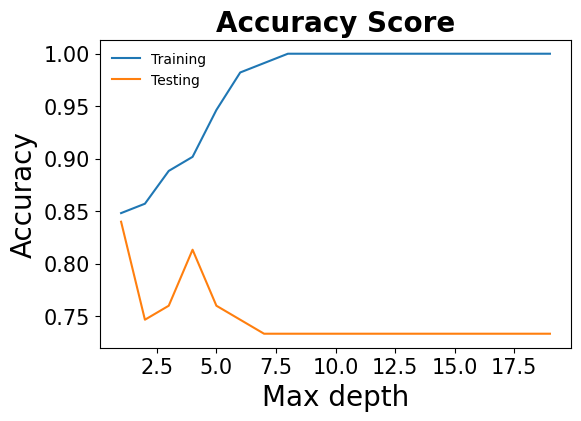

In [172]:
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

fig.add_subplot(2,2,1)
plt.plot(max_depth, training_accuracy, label='training accuracy')
plt.plot(max_depth, test_accuracy, label='test accuracy')
plt.ylabel('Accuracy',size=20)
plt.xlabel('Max depth',size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Accuracy Score',size=20, weight='bold')
plt.legend(['Training','Testing'],frameon=False)
plt.show()


As espected, the accuracy of training quickly tends to $1$ as the max depth increases. This is due to the very definition of overfitting a tree. We see a maximum of accuracy on training to max depth = 4.



In [173]:
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=1, random_state=0).fit(X_train, y_train)
y_pred=tree.predict(X_test)

print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))

Accuracy on test: 0.813


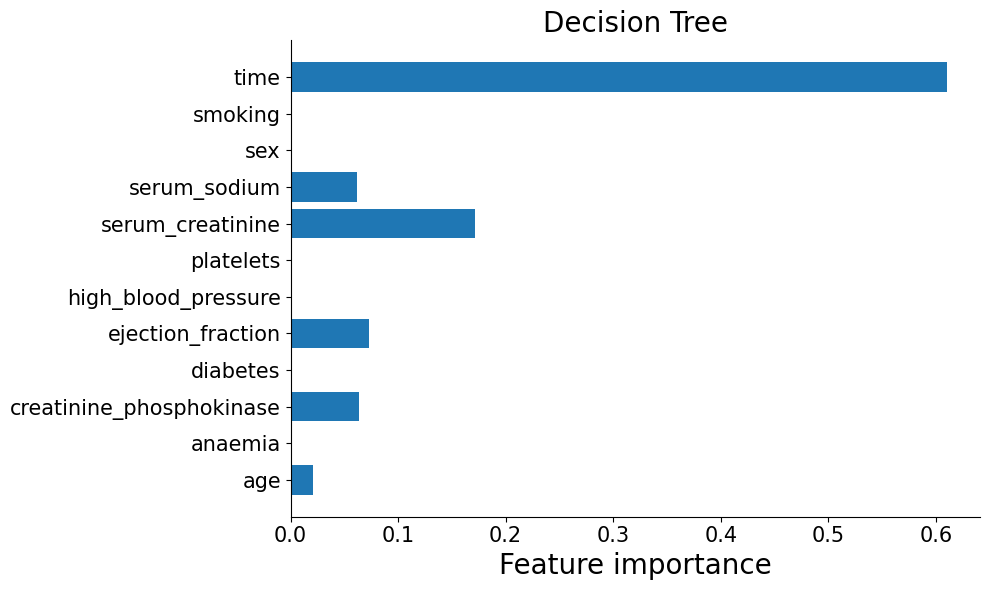

In [177]:


def plot_feature_importances(model, figure):
    n_features = 12
    plt.figure(figsize=(10,6))
    plt.barh(range(n_features), model.feature_importances_, align='center') # check documentation on model
    plt.yticks(np.arange(n_features), X,size=15)
    plt.xticks(size=15)
    plt.xlabel('Feature importance',size=20,)
    #plt.ylabel('Feature',size=20)
    plt.ylim(-1, n_features)
    sns.despine(top=True)
    plt.title(f'{figure}',size=20)
    plt.tight_layout()
    plt.savefig(f'feature-image{figure}.png',dpi=300)

plot_feature_importances(tree,'Decision Tree')

## Random forest


In [178]:
rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred=rf.predict(X_test)

print("Accuracy on test: {:.3f}".format(accuracy_score(y_pred, y_test)))


Accuracy on test: 0.827


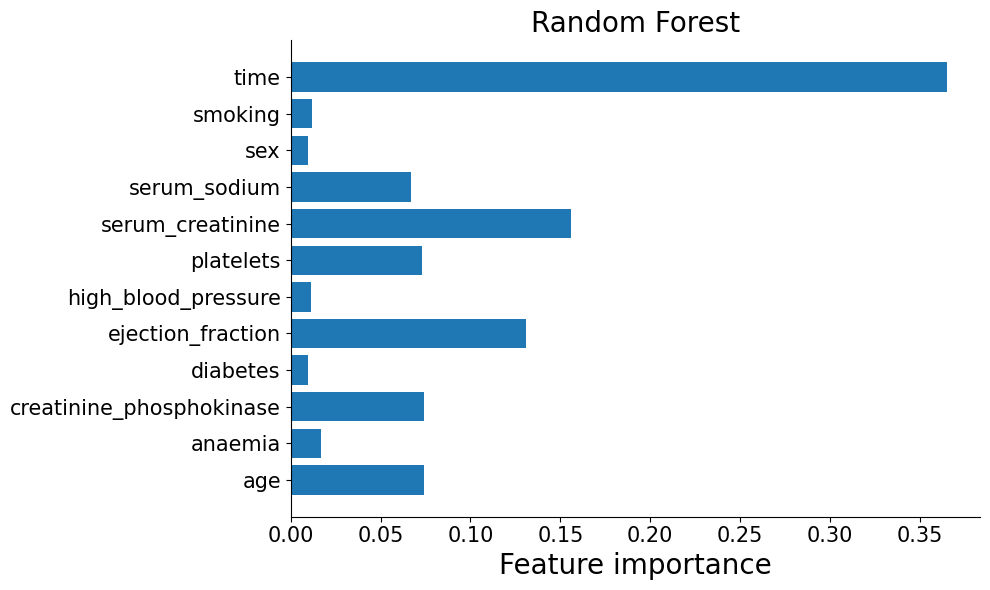

In [179]:
plot_feature_importances(rf, 'Random Forest')

Both models give similar results on feature importance, but as espected, random forest gives more insight. 